In [532]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imresize, imread
from tqdm import tqdm_notebook, tnrange
import cv2
from glob import glob
import pickle
import peakutils
from scipy.signal import find_peaks_cwt

%matplotlib inline
#%matplotlib qt

In [35]:
ROWS = 6
COLS = 9
CAL_IMAGE_SIZE = (720, 1280, 3)
CALC_CAL_POINTS = False
CAL_IMAGE_PATH = 'camera_cal/calibration*.jpg'
CALIBRATION_PATH = 'camera_cal/calibration.p'

def get_camera_calibration(path_pattern, rows, cols, image_size):
    objp = np.zeros((rows*cols,3), np.float32)
    objp[:,:2] = np.mgrid[0:cols, 0:rows].T.reshape(-1,2)

    objpoints = []
    imgpoints = []

    images = glob(path_pattern)
    cal_images = np.zeros((len(images), *CAL_IMAGE_SIZE), dtype=np.uint8)

    successfull_cnt = 0
    for idx, fname in enumerate(tqdm_notebook(images, desc='Processing image')):
        img = imread(fname)
        if img.shape[0] != CAL_IMAGE_SIZE[0] or img.shape[1] != CAL_IMAGE_SIZE[1]:
            img = imresize(img, CAL_IMAGE_SIZE)

        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (cols, rows), None) 

        if ret == True:
            successfull_cnt +=1

            objpoints.append(objp)
            imgpoints.append(corners)

            img = cv2.drawChessboardCorners(img, (cols, rows), corners, ret)
            cal_images[idx] = img

    print("%s/%s camera calibration images processed." % (successfull_cnt,len(images)))
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, CAL_IMAGE_SIZE[:-1], None, None)
    
    calibration = {'objpoints': objpoints,
                   'imgpoints': imgpoints,
                   'cal_images': cal_images,
                   'mtx': mtx,
                   'dist': dist,
                   'rvecs': rvecs,
                   'tvecs': tvecs}
    
    return calibration

if CALC_CAL_POINTS:
    calibration = get_camera_calibration(CAL_IMAGE_PATH, ROWS, COLS, CAL_IMAGE_SIZE)
    with open(CALIBRATION_PATH, 'wb') as f:
        pickle.dump(calibration, file=f)
else:
    with open(CALIBRATION_PATH, "rb" ) as f:
        calibration = pickle.load(f)   


17/19 camera calibration images processed.


In [1134]:
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

def abs_sobel_thresh(img_ch, orient='x', sobel_kernel=3, thresh=(0, 255)):  
    if orient == 'x':
        axis = (1, 0)
    elif orient == 'y':
        axis = (0, 1)
    else:
        raise ValueError('orient has to be "x" or "y" not "%s"' % orient)
    
    sobel = cv2.Sobel(img_ch, cv2.CV_64F, *axis)
    abss = np.absolute(sobel)
    
    scale_factor = np.max(abss)/255
    abss = (abss/scale_factor).astype(np.uint8)
    
    binary_output = np.zeros_like(abss)
    binary_output[(abss > thresh[0]) & (abss < thresh[1])] = 1
    
    return binary_output

def mag_thresh(img_ch, sobel_kernel=3, thresh=(0, 255)):    
    sobelx = cv2.Sobel(img_ch, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_ch, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_grad_mag = np.sqrt(sobelx**2+sobely**2)

    scale_factor = np.max(abs_grad_mag)/255
    abs_grad_mag = (abs_grad_mag/scale_factor).astype(np.uint8)
    
    mag_binary = np.zeros_like(abs_grad_mag)
    mag_binary[(abs_grad_mag > thresh[0]) & (abs_grad_mag < thresh[1])] = 1

    return mag_binary

def dir_threshold(img_ch, sobel_kernel=3, thresh=(0, np.pi/2)):    
    sobelx = cv2.Sobel(img_ch, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_ch, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    with np.errstate(divide='ignore', invalid='ignore'):
        abs_grad_dir = np.absolute(np.arctan(sobely/sobelx))
        dir_binary =  np.zeros_like(abs_grad_dir)
        dir_binary[(abs_grad_dir > thresh[0]) & (abs_grad_dir < thresh[1])] = 1

    return dir_binary

def hls_select(img, ch, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_ch = hls[:,:,ch]
    retval, ch_binary = cv2.threshold(s_ch.astype('uint8'), thresh[0], thresh[1], cv2.THRESH_BINARY)

    return ch_binary

def hsv_select(img, ch, thresh=(0, 255)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    v_channel = hsv[:,:,ch]
    retval, ch_binary = cv2.threshold(v_channel.astype('uint8'), 220, 255, cv2.THRESH_BINARY)

    return ch_binary

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def apply_mask(mask, img):
    detected = np.copy(orig_img)

    detected[mask[:,:,0] > 0, 0] = 255
    detected[mask[:,:,0] > 0, 1:] = 0

    detected[mask[:,:,1] > 0, 1] = 255
    detected[mask[:,:,1] > 0, 2] = 0
    detected[mask[:,:,1] > 0, 0] = 0

    detected[mask[:,:,2] > 0, 2] = 255
    detected[mask[:,:,2] > 0, :2] = 0
    
    return detected

In [1144]:
def get_thresholded_image(img, ksize=3):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    v_channel = hsv[:,:,2]
    
    v_binary = hsv_select(img, 2, thresh=(220, 255))
    s_binary = hls_select(img, 2, thresh=(220, 255))

    
    gradx = abs_sobel_thresh(v_channel, orient='x', sobel_kernel=ksize, thresh=(20, 255))
    grady = abs_sobel_thresh(v_channel, orient='y', sobel_kernel=ksize, thresh=(30, 255))
    mag_binary = mag_thresh(v_channel, sobel_kernel=ksize, thresh=(60, 255))
    dir_binary = dir_threshold(v_channel, sobel_kernel=ksize, thresh=(np.pi/4, np.pi/3))

    combined = np.zeros_like(grady)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 255
    
    color_binary = np.dstack((np.zeros_like(s_binary), s_binary, v_binary))
    gray = cv2.cvtColor(color_binary, cv2.COLOR_RGB2GRAY)
    _, final = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
    return v_binary|s_binary

In [1155]:
class PerspectiveTransformer():
    def __init__(self, src, dst):
        self.src = src
        self.dst = dst
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.M_inv = cv2.getPerspectiveTransform(dst, src)

    def transform(self, img):
        return cv2.warpPerspective(img, self.M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    
    def inverse_transform(self, img):
        return cv2.warpPerspective(img, self.M_inv, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)

In [1156]:
def color_peak_square(lane_img, img, start, end, peak, pixels_per_step, ch):
    lane_img[start:end,
        peak-pixels_per_step//2:peak+pixels_per_step//2,
        ch] = \
    img[start:end,
        peak-pixels_per_step//2:peak+pixels_per_step//2]

def mark_lanes(img, steps):
    lane_img = np.zeros((*img.shape, 3), dtype=np.uint8)

    for i in range(steps):
        pixels_per_step = img.shape[0]//steps
        start = i * pixels_per_step
        end = start + pixels_per_step
        histogram = np.sum(img[start:end,:], axis=0)

        peaks = find_peaks_cwt(histogram, np.arange(1, 50))
        if len(peaks) == 2:
            color_peak_square(lane_img, img, start, end, peaks[0], pixels_per_step, 2)
            color_peak_square(lane_img, img, start, end, peaks[1], pixels_per_step, 0)
        elif len(peaks) == 1:
            if peaks[0] < img.shape[1]:
                color_peak_square(lane_img, img, start, end, peaks[0], pixels_per_step, 2)
            else:
                color_peak_square(lane_img, img, start, end, peaks[0], pixels_per_step, 0)
    
    return lane_img

In [1157]:
def get_poly(img, ch):
    y, x = (img[:,:,ch]==255).nonzero()
    z = np.polyfit(y, x, 2)
    return np.poly1d(z)

In [1158]:
def calculate_lane_area(polys, img_height, steps):
    points_left = np.zeros((steps + 1, 2))
    points_right = np.zeros((steps + 1, 2))

    for i in range(steps + 1):
        pixels_per_step = img_height//steps
        start = img_height - i * pixels_per_step

        points_left[i] = [polys[0](start), start]
        points_right[i] = [polys[1](start), start]

    return np.concatenate((points_left, points_right[::-1]), axis=0)

In [1161]:
HIST_STEPS = 10
SRC = np.float32([
    (280, 720),
    (530, 500),
    (780, 500),
    (1200, 720)])

DST = np.float32([
    (280, 720),
    (280, 0),
    (1200, 0),
    (1200, 720)])

def image_pipline(img, calibration):
    orign_img = np.copy(img)
    
    # 1. Apply the distortion correction to the raw image.
    img = cal_undistort(img, calibration['objpoints'], calibration['imgpoints'])
    
    # 2. Use color transforms, gradients, etc., to create a thresholded binary image.
    img = gaussian_blur(img, kernel_size=5)
    img = get_thresholded_image(img)
    
    # 3. Apply a perspective transform to rectify binary image ("birds-eye view").
    pt = PerspectiveTransformer(SRC, DST)
    img = pt.transform(img)
    
    # 4. Detect lane pixels and fit to find lane boundary.
    img = mark_lanes(img, HIST_STEPS)
    
    # 5. Determine curvature of the lane and vehicle position with respect to center.
    # the left lane will be displayed blue therefore assigned to channel 3 (RGB)
    # the right lane will be displayed red therefore assigned to channel 1 (RGB)
    p_left = get_poly(img, 2)
    p_right = get_poly(img, 0)
    
    # Draw lane area
    lane_area = calculate_lane_area((p_left, p_right), img.shape[0], HIST_STEPS)
    img = cv2.fillPoly(img, np.int32([lane_area]), (0,255,0))
    
    # 6. Warp the detected lane boundaries back onto the original image.
    img = pt.inverse_transform(img)
    
    # 7. Add lane boundaries and numerical estimation of lane curvature and vehicle position.
    img = apply_mask(img, orign_img)
    
    return img

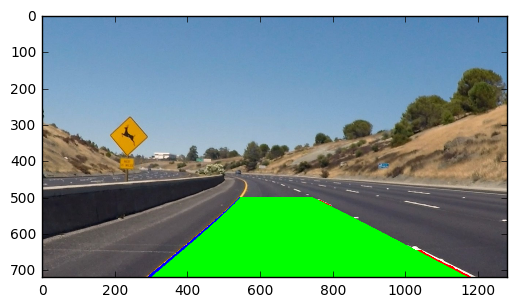

In [1162]:
orig_img = imread('test_images/test2.jpg')
img = image_pipline(orig_img, calibration)

plt.imshow(img)